<a href="https://colab.research.google.com/github/pamelabrg/mandelbrot-generator/blob/main/Fractal_Mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código em C onde é realizado todo o cálculo para geração da imagem do Fractal Mandelbrot, utilizando o %%writefile, tudo que vem a seguir é escrito em um arquivo do sistema.

In [ ]:
%%writefile mandelbrot.c

#include <stdio.h>
#include <stdlib.h>

void mandelbrot(int width, int height, int max_iter, double center_x, double center_y, double zoom, const char* filename) {
    FILE* fp = fopen(filename, "wb");
    if (!fp) {
        perror("fopen");
        exit(EXIT_FAILURE);
    }

    double real_range = 4.0 / zoom;
    double imag_range = 4.0 / zoom;
    double real_min = center_x - (real_range / 2);
    double real_max = center_x + (real_range / 2);
    double imag_min = center_y - (imag_range / 2);
    double imag_max = center_y + (imag_range / 2);

    fwrite(&width, sizeof(int), 1, fp);
    fwrite(&height, sizeof(int), 1, fp);
    fwrite(&max_iter, sizeof(int), 1, fp);
    fwrite(&real_min, sizeof(double), 1, fp);
    fwrite(&real_max, sizeof(double), 1, fp);
    fwrite(&imag_min, sizeof(double), 1, fp);
    fwrite(&imag_max, sizeof(double), 1, fp);

    unsigned char* image = (unsigned char*)malloc(width * height);
    if (!image) {
        perror("malloc");
        exit(EXIT_FAILURE);
    }

    for (int y = 0; y < height; ++y) {
        for (int x = 0; x < width; ++x) {
            double cx = real_min + (x / (double)width) * (real_max - real_min);
            double cy = imag_min + (y / (double)height) * (imag_max - imag_min);
            double zx = 0.0, zy = 0.0;
            int i;
            for (i = 0; i < max_iter; ++i) {
                double xtemp = zx * zx - zy * zy + cx;
                zy = 2.0 * zx * zy + cy;
                zx = xtemp;
                if (zx * zx + zy * zy > 4.0) break;
            }
            image[y * width + x] = (unsigned char)(255.0 * i / max_iter);
        }
    }

    fwrite(image, sizeof(unsigned char), width * height, fp);
    fclose(fp);
    free(image);
}

int main(int argc, char* argv[]) {
    if (argc != 8) {
        fprintf(stderr, "Usage: %s width height max_iter center_x center_y zoom output_file\n", argv[0]);
        return EXIT_FAILURE;
    }

    int width = atoi(argv[1]);
    int height = atoi(argv[2]);
    int max_iter = atoi(argv[3]);
    double center_x = atof(argv[4]);
    double center_y = atof(argv[5]);
    double zoom = atof(argv[6]);
    const char* output_file = argv[7];

    mandelbrot(width, height, max_iter, center_x, center_y, zoom, output_file);
    return EXIT_SUCCESS;
}


Writing mandelbrot.c


Compilação do código C

In [ ]:
!gcc mandelbrot.c -o mandelbrot -lm

Alternativa ao Makefile no ambiente do Colab

In [ ]:
%%writefile input.txt
1080
1080
500
-0.5
0.0
1.0


Writing input.txt


É lido o arquivo com o caso de estudo, Utilizando Subprocessos, conseguimos executar o código C, já compilado, e calcular o fractal. Os dados são salvos em um arquivo binário e posteriormente lidos para gerar o PNG.

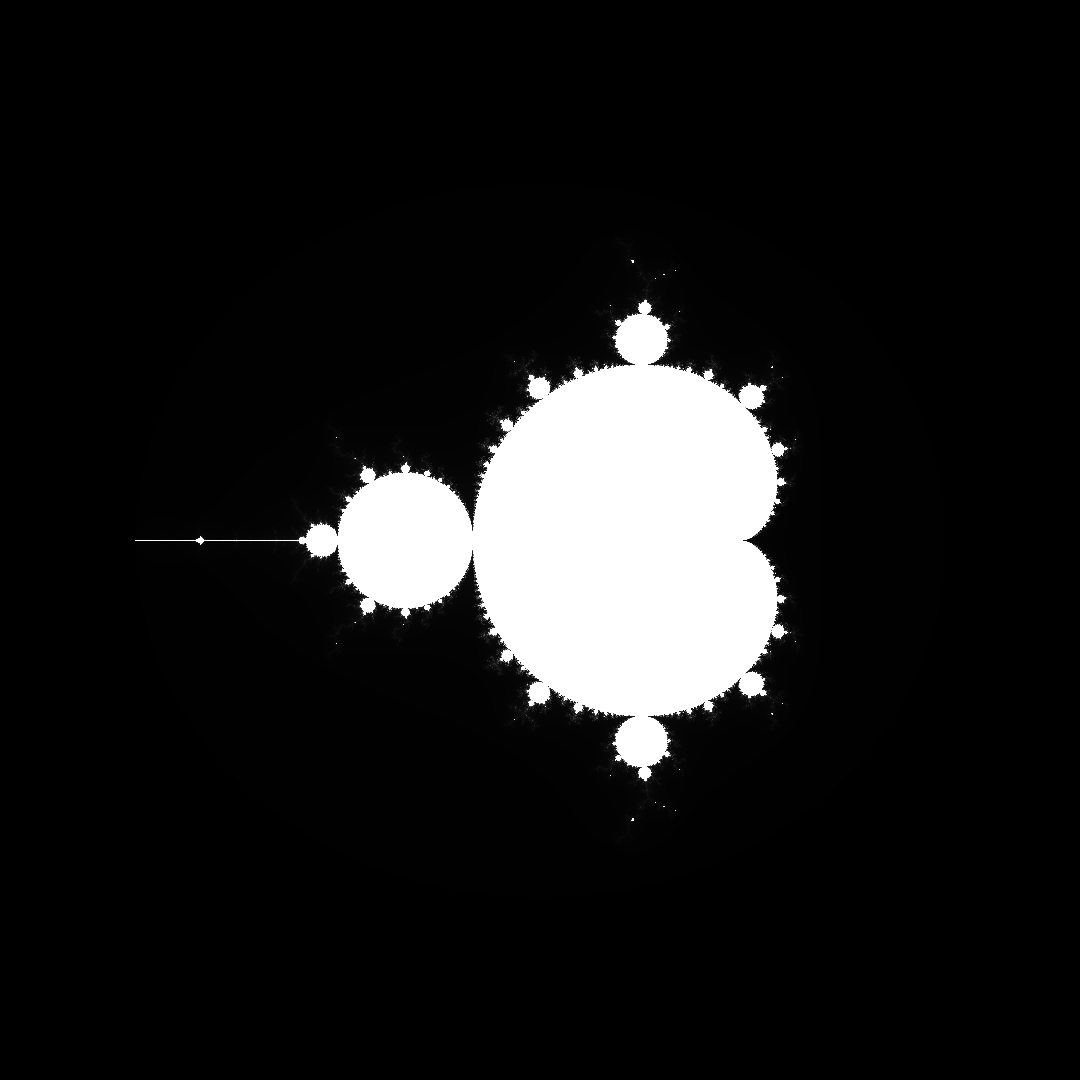

In [ ]:
import subprocess
import numpy as np
from PIL import Image

def generate_fractal(binary_file, png_file):
    # Lê os valores do arquivo de entrada
    with open('input.txt', 'r') as f:
        width = int(f.readline().strip())
        height = int(f.readline().strip())
        max_iter = int(f.readline().strip())
        center_x = float(f.readline().strip())
        center_y = float(f.readline().strip())
        zoom = float(f.readline().strip())

    # Chama o programa C para calcular o fractal
    subprocess.run([
        './mandelbrot',
        str(width), str(height), str(max_iter),
        str(center_x), str(center_y),
        str(zoom), binary_file
    ], check=True)

    # Lê os dados binários gerados pelo programa C
    with open(binary_file, 'rb') as f:
        width = np.fromfile(f, dtype=np.int32, count=1)[0]
        height = np.fromfile(f, dtype=np.int32, count=1)[0]
        max_iter = np.fromfile(f, dtype=np.int32, count=1)[0]
        real_min = np.fromfile(f, dtype=np.float64, count=1)[0]
        real_max = np.fromfile(f, dtype=np.float64, count=1)[0]
        imag_min = np.fromfile(f, dtype=np.float64, count=1)[0]
        imag_max = np.fromfile(f, dtype=np.float64, count=1)[0]

        image_data = np.fromfile(f, dtype=np.uint8).reshape((height, width))

    # Cria e salva a imagem PNG
    image = Image.fromarray(image_data, mode='L')
    image.save(png_file)

def main():
    binary_file = 'mandelbrot_data.bin'
    png_file = 'mandelbrot.png'
    generate_fractal(binary_file, png_file)

if __name__ == '__main__':
    main()

from IPython.display import Image as IPImage
IPImage('mandelbrot.png')


In [ ]:
# Limpeza dos arquivos gerados
!rm -f mandelbrot mandelbrot.c mandelbrot_data.bin mandelbrot.png
print('OK')

OK
